In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage.measure import regionprops
from skimage.morphology import convex_hull_image

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression

import catboost
from pyexcel_ods import get_data

import albumentations
from albumentations import Compose, PadIfNeeded, Resize
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

In [38]:
path = 'sandstone/images'
target_path = 'sandstone/NN/sand_calc.ods'

data = get_data(target_path)
df = pd.DataFrame(data['Sheet1'][1:], columns=data['Sheet1'][0]).set_index('mod_no')

images = []
Y = []
resized = []
for fname in sorted(os.listdir(path)):
    name, ext = fname.split('.')
    if ext != 'bmp':
        continue
    Y.append(df.loc[name, 'cd/area^2'])
    fpath = os.path.join(path, fname)
    img = mpimg.imread(fpath)
    img = (255 - img).astype(bool).astype(int)
    rescale = Compose([
        albumentations.PadIfNeeded(min_height=np.max(img.shape), 
                                   min_width=np.max(img.shape),
                                   border_mode=0,
                                   always_apply=True),
        albumentations.Resize(height=22, width=22, interpolation=0, always_apply=True)
    ], p=1)
    resized.append(rescale(image=img)['image'])

#     img = 255 - np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = (255 - img).astype(np.float64) / 255
#     img = np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = imread(fpath)
    images.append(img)
# Y = np.array(Y, dtype=np.float64)

In [40]:
len(Y)

2228

In [41]:
path = 'carb/images'
target_path = 'carb/NN/carb_calc.ods'

data = get_data(target_path)
df = pd.DataFrame(data['Sheet1'][1:], columns=data['Sheet1'][0]).set_index("'mod_no'")

images = []
Y = []
resized = []
for fname in sorted(os.listdir(path)):
    name, ext = fname.split('.')
    if ext != 'bmp':
        continue
    try:
#             y = float(df.loc["'" + name + "'", "'cd/area^2'"][1:-1])
        y = float(df.loc["'" + name + "'", "'cd/area^2'"][1:-1])
        Y.append(y)
    except KeyError:
        print('No results in table: {}!'.format(name))
#     Y.append(df.loc["'" + name + "'", "'cd/area^2'"])
    fpath = os.path.join(path, fname)
    img = mpimg.imread(fpath)
    img = (255 - img).astype(bool).astype(int)
    rescale = Compose([
        albumentations.PadIfNeeded(min_height=np.max(img.shape), 
                                   min_width=np.max(img.shape),
                                   border_mode=0,
                                   always_apply=True),
        albumentations.Resize(height=22, width=22, interpolation=0, always_apply=True)
    ], p=1)
    resized.append(rescale(image=img)['image'])

#     img = 255 - np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = (255 - img).astype(np.float64) / 255
#     img = np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = imread(fpath)
    images.append(img)
# Y = np.array(Y, dtype=np.float64)

In [42]:
len(images)

1084

In [43]:
path = 'soil_results/'
target_path = 'soil_results/Geom_eval.xls'

#     data = get_data(target_path)
#     df = pd.DataFrame(data['Sheet1'][1:], columns=data['Sheet1'][0]).set_index('mod_no')
#     df = pd.DataFrame(data['Sheet1'][1:], columns=data['Sheet1'][0]).set_index("'mod_no'")
df = pd.read_excel(target_path, header=0).set_index("mod_no")
images = []
Y = []
for i, fname in enumerate(sorted(os.listdir(path))):
    if len(fname.split('.')) != 2:
        continue
    name, ext = fname.split('.')
    if ext != 'bmp':
        continue
#         Y.append(df.loc[name, 'cd/area^2'])
    try:
#             y = float(df.loc["'" + name + "'", "'cd/area^2'"][1:-1])
        y = float(df.loc[name, "'cd/area^2'"][1:-1])
        Y.append(y)
    except KeyError:
        print('No results in table: {}!'.format(name))

    fpath = os.path.join(path, fname)
    img = mpimg.imread(fpath)
    if len(img.shape) > 2:
        img = img[:, :, 0]

    img = (255 - img).astype(bool)
    x, y = np.where(img)
    cropped = img[np.min(x) : np.max(x)+1, np.min(y) : np.max(y)+1]
    size = max(*cropped.shape)
    padded = np.zeros((int(size * 1.5) + 1, int(size * 1.5) + 1))
    l = int(0.25 * size) + 1
    u = int(0.25 * size) + 1
    padded[l : l+cropped.shape[0], u : u+cropped.shape[1]] = cropped
    img = np.repeat(padded.reshape(padded.shape[0], padded.shape[1], 1), 3, axis=2).astype(np.float64)
    images.append(img)
Y = np.array(Y, dtype=np.float64)
print(len(Y))

508


In [4]:
images[2].shape

(45, 55)

In [5]:
import imp
import plots

In [6]:
imp.reload(plots)

<module 'plots' from '/home/evlavrukhin/speed_calc/plots.py'>

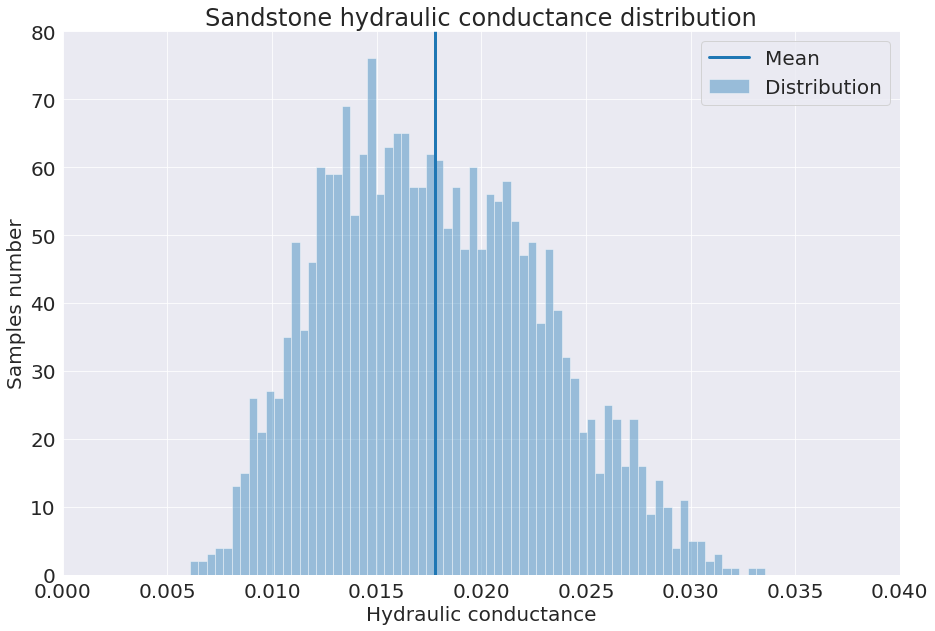

In [10]:
plots.plot_targets(Y, 'Sandstone hydraulic conductance distribution', 'poster_images/sandstone_targets', maxy=80, maxx=0.04)

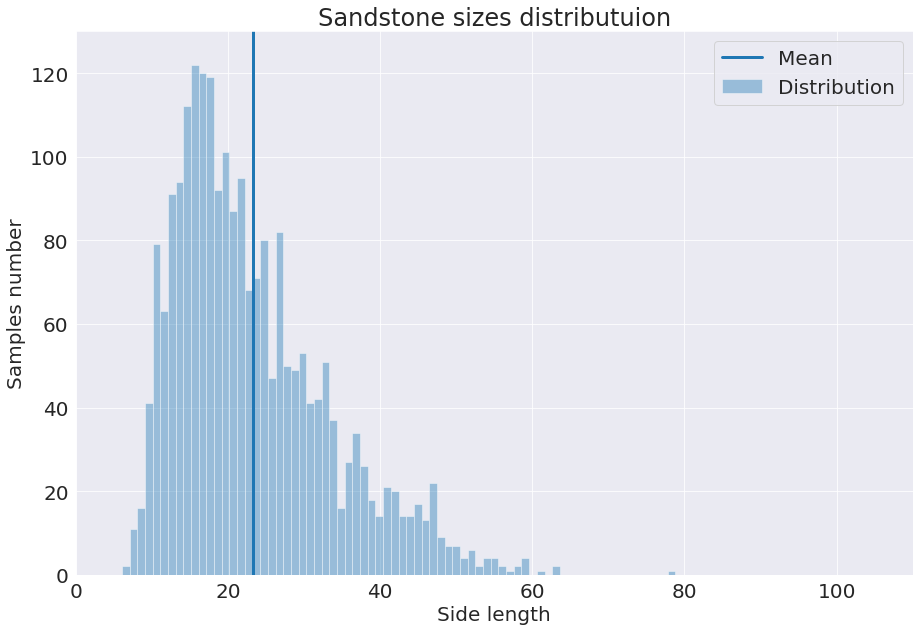

In [16]:
sizes = [np.sqrt(img.shape[0] * img.shape[1]) for img in images]
plots.plot_sizes(sizes, 'Sandstone sizes distributuion', 'poster_images/sandstone_sizes', maxx=110, maxy=130)

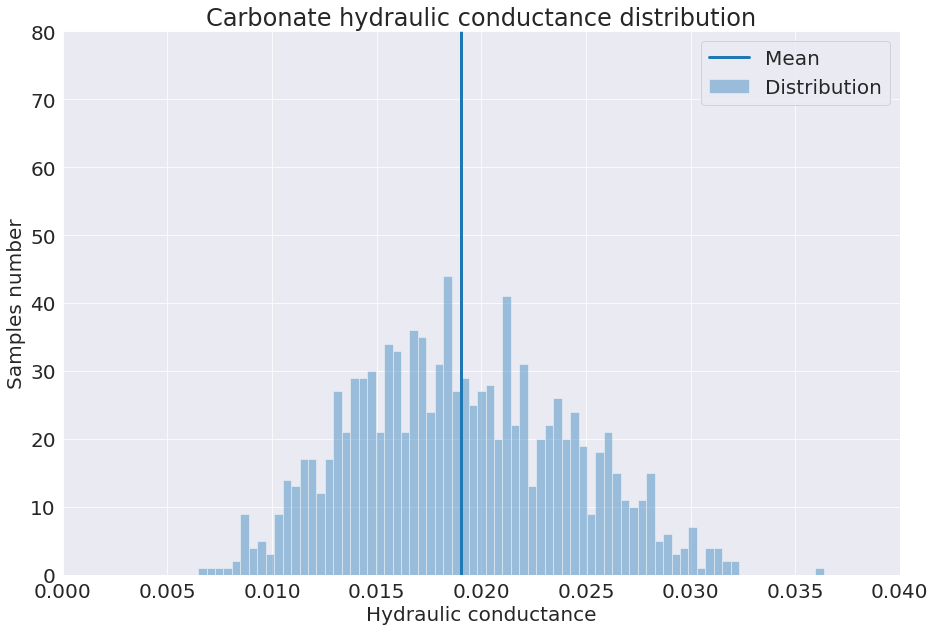

In [33]:
plots.plot_targets(Y, 'Carbonate hydraulic conductance distribution', 'poster_images/carb_targets', maxy=80, maxx=0.04)

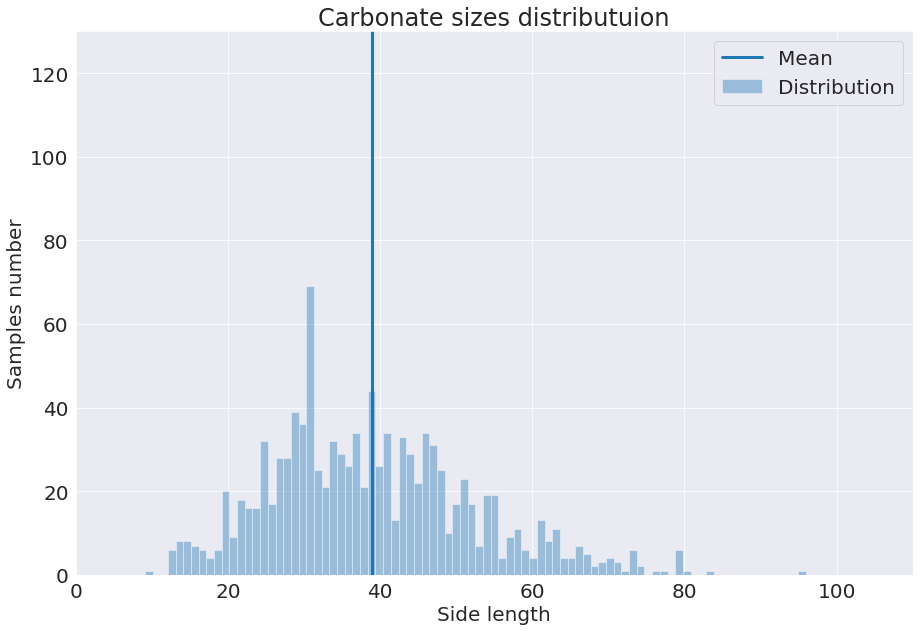

In [24]:
sizes = [np.sqrt(img.shape[0] * img.shape[1]) for img in images]
plots.plot_sizes(sizes, 'Carbonate sizes distributuion', 'poster_images/carb_sizes', maxx=110, maxy=130)

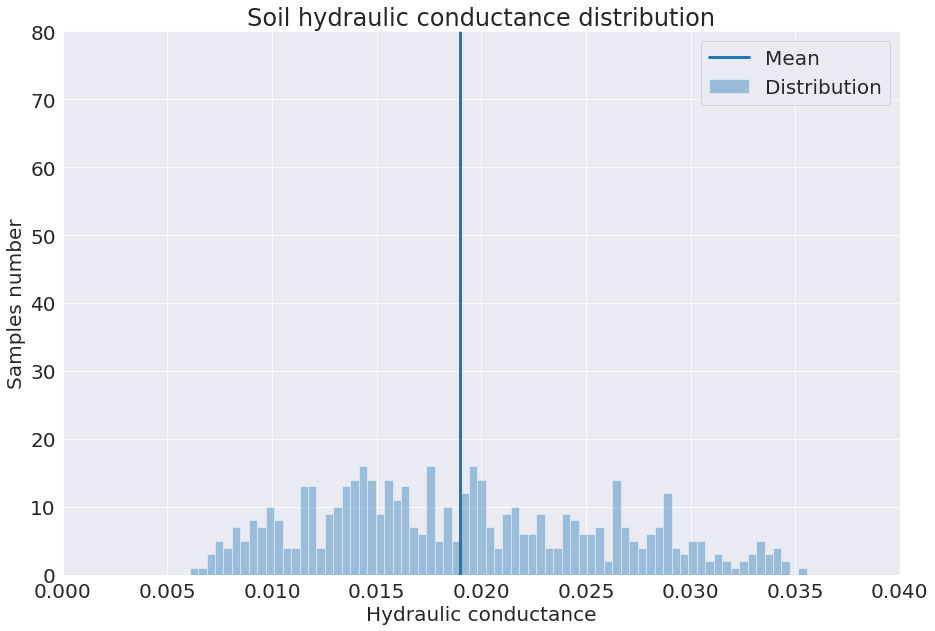

In [35]:
plots.plot_targets(Y, 'Soil hydraulic conductance distribution', 'poster_images/soil_targets', maxy=80, maxx=0.04)

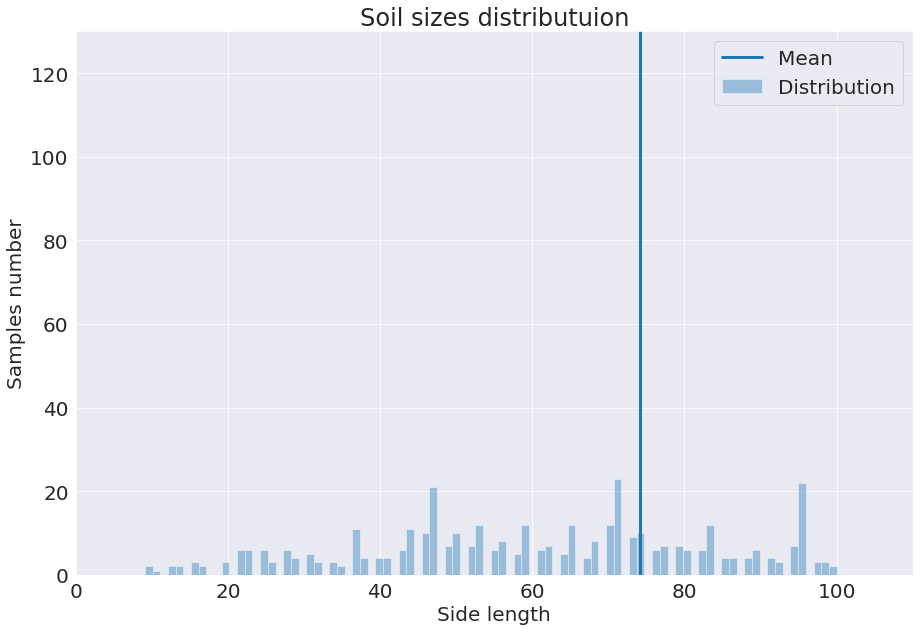

In [36]:
sizes = [np.sqrt(img.shape[0] * img.shape[1]) for img in images]
plots.plot_sizes(sizes, 'Soil sizes distributuion', 'poster_images/soil_sizes', maxx=110, maxy=130)

In [234]:
import augmentations
from augmentations import augment_flips_color, pad_img, augment, augment_and_show

h = 128
w = 128
train_aug = augment_flips_color(h, w, interpolation=0)
test_aug = pad_img(h, w, interpolation=0)

In [235]:
def augment_data(X, Y, times, aug):
    augmented_X = []
    augmented_Y = []
    for _ in range(times):
        for (x, y) in zip(X, Y):
            augmented_X.append(augment(aug, x))
            augmented_Y.append(y)
    X.extend(augmented_X)
    Y.extend(augmented_Y)
    X, Y = shuffle(X, Y)
    return X, Y

In [236]:
def split_data(images, Y, augment_train, augment_test, times):
    imgs_train, imgs_test, Y_train, Y_test = \
        train_test_split(images, Y, test_size=0.1, shuffle=True)
    if augment_train:
        imgs_train, Y_train = augment_data(imgs_train, Y_train, times, train_aug)
    if augment_test:
        imgs_test, Y_test = augment_data(imgs_test, Y_test, times, test_aug)
    return imgs_train, imgs_test, Y_train, Y_test

In [237]:
def calc_features(img, use_intensity=False):
    if use_intensity:
        label = (img > (255 / 2)).astype(int)
        props = regionprops(label_image=label, intensity_image=img/255)[0]
    else:
        props = regionprops(img)[0]
        
    circularity = 4 * np.pi * props.area / (props.perimeter ** 2)
    convexity = props.convex_area / props.area
    m = props.moments_central
    x = m[2, 0] + m[0, 2]
    y = (4 * m[1, 1] ** 2 + (m[2, 0] - m[0, 2]) ** 2) ** (0.5) 
    elongation = (x + y) / (x - y)
    
    features = ([
            circularity, 
            convexity, 
            elongation,
            props.eccentricity, 
            props.equivalent_diameter / props.perimeter, 
            props.extent, 
            props.minor_axis_length / props.perimeter,
            props.major_axis_length / props.perimeter,
        ]
        + list(props.inertia_tensor_eigvals / props.area)
        + list(props.moments_hu)
    )
    
    return np.array(features).reshape((1, -1))

In [238]:
times = 10

In [239]:
metrics = {
    'mse': lambda true, pred: ((true - pred) ** 2).mean(),
    'mape': lambda true, pred: np.abs((true - pred) / true).mean(),
}

In [240]:
from sklearn.model_selection import KFold

In [241]:
Y = np.array(Y)

In [242]:
def validate(augment_train=False, augment_test=False, scale_Y=False, times=10):
    train = {k: [] for k in metrics}
    test = {k: [] for k in metrics}
    
    pred = []
    gt = []
    models = []
    for i in range(times):
        print(i)
        folds = KFold(n_splits=10)
        for train_idxes, test_idxes in folds.split(images, Y):
            train_images = [images[j] for j in train_idxes]
            test_images = [images[j] for j in test_idxes]
            
            Y_train = Y[train_idxes]
            Y_test = Y[test_idxes]
            if augment_train:
                train_images, Y_train = augment_data(train_images, Y_train, 1, train_aug)
            if augment_test:
                images_test, Y_test = augment_data(images_test, Y_test, 1, test_aug)
    
            X_train = np.concatenate([calc_features(img) for img in train_images], axis=0)
            X_test = np.concatenate([calc_features(img) for img in test_images], axis=0)
#             X_scaler = StandardScaler().fit(X_train)
#             X_train = X_scaler.transform(X_train)
#             X_test = X_scaler.transform(X_test)
        
            if scale_Y:
                Y_scaler = StandardScaler().fit(Y_train.reshape(-1, 1))
                Y_train = Y_scaler.transform(Y_train.reshape(-1, 1)).flatten()

#             model = LinearRegression().fit(X_train, Y_train)
#             pred_train = model.predict(X_train)
#             pred_test = model.predict(X_test)
#             pred_train = model.predict(X_train)
#             pred_test = model.predict(X_test)

            params = {
                'iterations': 3000,
                'depth': 3,
                'loss_function': 'RMSE',
                'task_type': 'GPU'
            }
            model = catboost.CatBoostRegressor(**params)
            train_pool = catboost.Pool(X_train, Y_train)
            test_pool = catboost.Pool(X_test, Y_test)
            model.fit(train_pool, verbose=False)
            pred_train = model.predict(train_pool)
            pred_test = model.predict(test_pool)

            if scale_Y:
                Y_train = Y_scaler.inverse_transform(Y_train.reshape(-1, 1)).flatten()
                pred_train = Y_scaler.inverse_transform(pred_train.reshape(-1, 1)).flatten()
                pred_test = Y_scaler.inverse_transform(pred_test.reshape(-1, 1)).flatten()

    #     pred = Y_scaler.inverse_transform(pred)
            for k, v in metrics.items():
                test[k].append(v(Y_test, pred_test))
                train[k].append(v(Y_train, pred_train))
            pred.append(pred_test)
            gt.append(Y_test)
            models.append(model)
    return np.concatenate(pred), np.concatenate(gt), train, test, models

In [243]:
%%time
pred, gt, train_perf, test_perf, models = validate(augment_train=False, augment_test=False, times=1)

0


CPU times: user 5min 45s, sys: 36.5 s, total: 6min 22s
Wall time: 2min 26s


In [188]:
import imp
imp.reload(plots)

<module 'plots' from '/home/evlavrukhin/speed_calc/plots.py'>

In [189]:
import plots

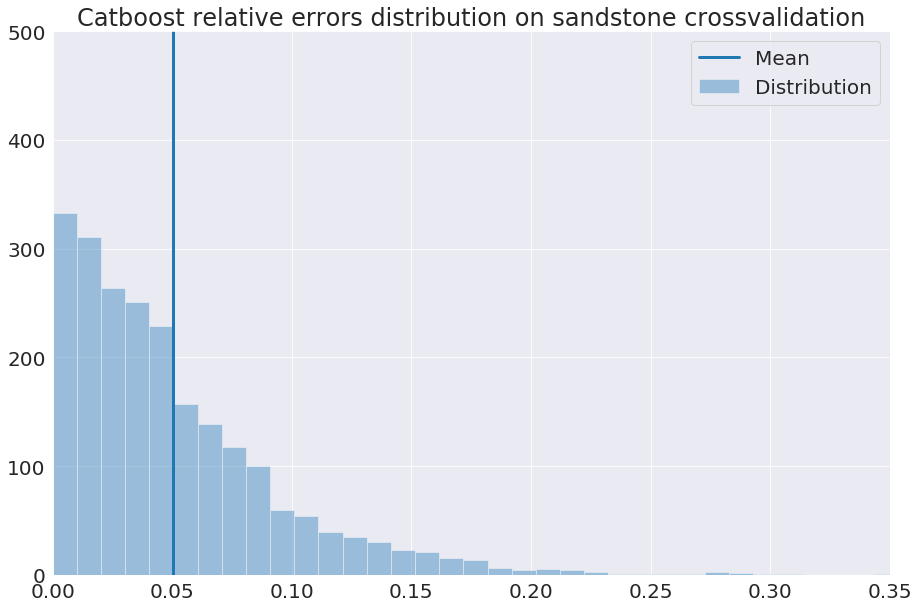

In [190]:
plots.plot_mape(gt, pred, 'Catboost relative errors distribution on sandstone crossvalidation', 'catboost_sand')

In [281]:
path = 'carb/images'
target_path = 'carb/NN/carb_calc.ods'

data = get_data(target_path)
df = pd.DataFrame(data['Sheet1'][1:], columns=data['Sheet1'][0]).set_index("'mod_no'")

images = []
Y = []
resized = []
for fname in sorted(os.listdir(path)):
    name, ext = fname.split('.')
    if ext != 'bmp':
        continue
    Y.append(float(df.loc["'" + name + "'", "'cd/area^2'"][1:-1]))
    fpath = os.path.join(path, fname)
    img = mpimg.imread(fpath)
    img = (255 - img).astype(bool).astype(int)
    rescale = Compose([
        albumentations.PadIfNeeded(min_height=np.max(img.shape), 
                                   min_width=np.max(img.shape),
                                   border_mode=0,
                                   always_apply=True),
        albumentations.Resize(height=22, width=22, interpolation=0, always_apply=True)
    ], p=1)
    resized.append(rescale(image=img)['image'])

#     img = 255 - np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = (255 - img).astype(np.float64) / 255
#     img = np.repeat(img.reshape(*img.shape, 1), 3, axis=2)
#     img = imread(fpath)
    images.append(img)
Y = np.array(Y, dtype=np.float64)

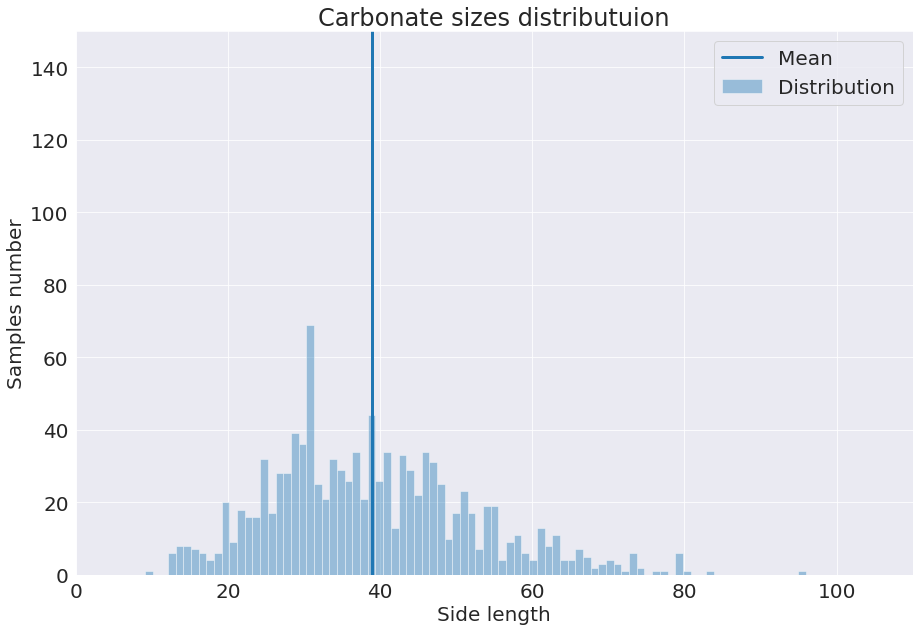

In [282]:
sizes = [np.sqrt(img.shape[0] * img.shape[1]) for img in images]
plots.plot_sizes(sizes, 'Carbonate sizes distributuion', 'carb_sizes', maxx=110, maxy=150)

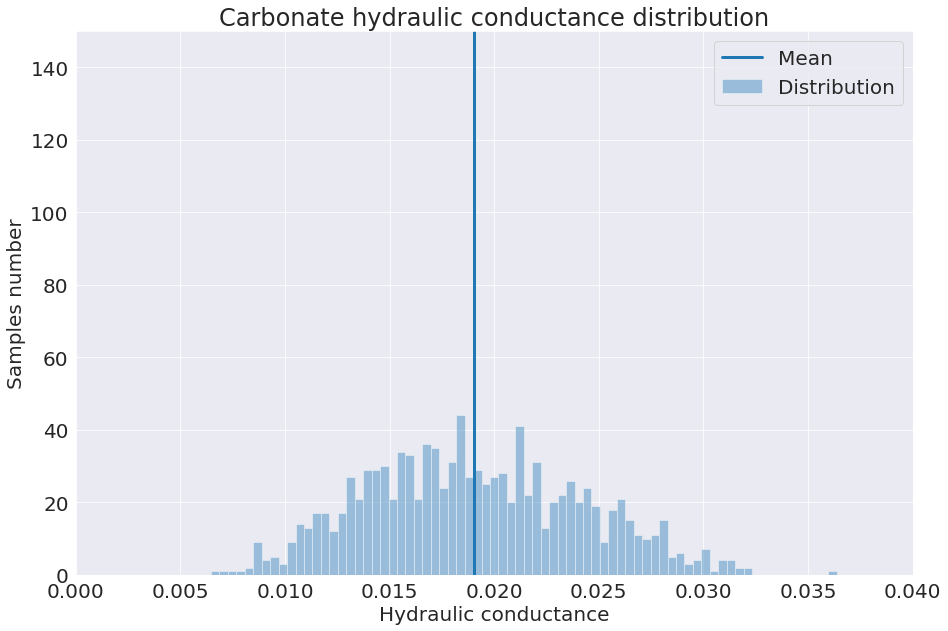

In [283]:
plots.plot_targets(Y, 'Carbonate hydraulic conductance distribution', 'carb_targets', maxy=150, maxx=0.04)

In [196]:
%%time
pred, gt, train_perf, test_perf, models = validate(augment_train=False, augment_test=False, times=1)

0


CPU times: user 1h 25min 56s, sys: 12min 39s, total: 1h 38min 35s
Wall time: 47min 40s


In [192]:
X = np.concatenate([calc_features(img) for img in images], axis=0)
Y = np.array(Y)
pred = np.zeros_like(Y, dtype=np.float64)

pool = catboost.Pool(X, Y)
for model in models:
    pred += model.predict(pool)
pred /= 10
gt = np.copy(Y)

In [163]:
gt

array([0.02658582, 0.01826345, 0.01925956, ..., 0.01336322, 0.01665612,
       0.01823942])

In [198]:
((gt - pred) ** 2).mean()

2.094822785404203e-06

In [229]:
imp.reload(plots)

<module 'plots' from '/home/evlavrukhin/speed_calc/plots.py'>

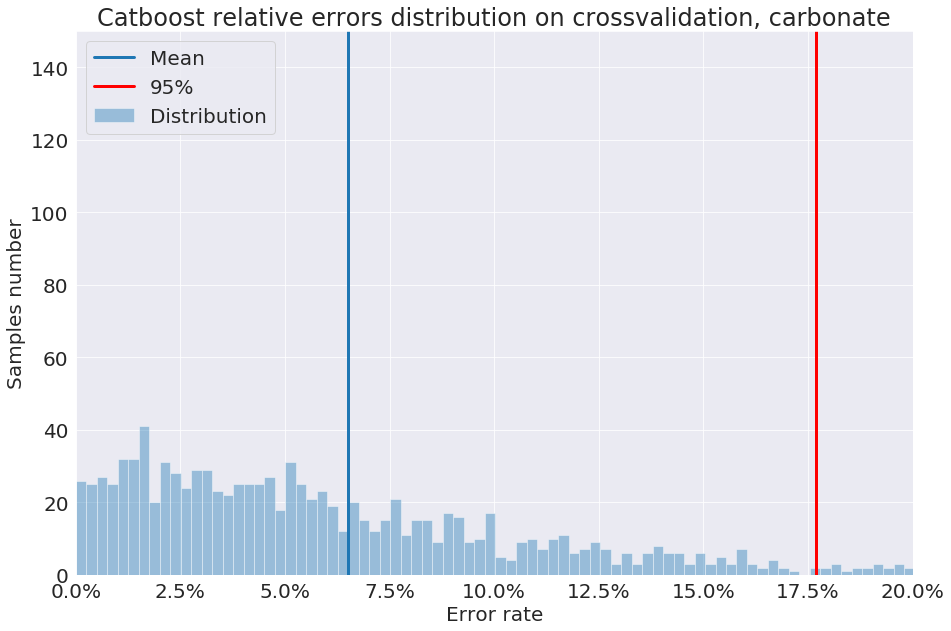

In [231]:
plots.plot_mape(gt, pred, 'Catboost relative errors distribution on crossvalidation, carbonate', 'catboost_carb', maxy=150, maxx=0.2)

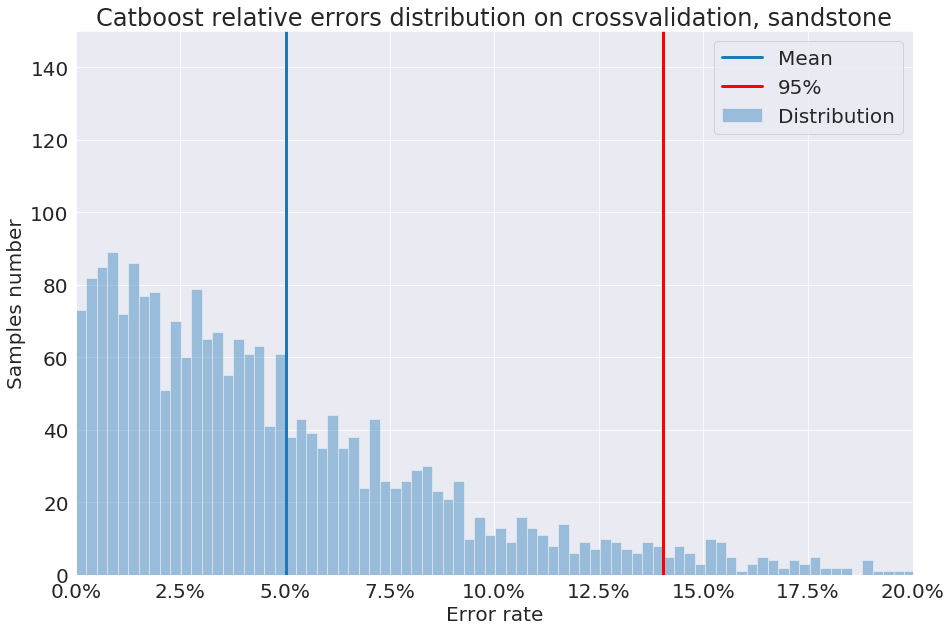

In [245]:
plots.plot_mape(gt, pred, 'Catboost relative errors distribution on crossvalidation, sandstone', 'catboost_sand', maxy=150, maxx=0.2)